In [1]:
import sys, os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import List, Tuple, Callable, Any, Dict


from methods.PolyCG.polycg.transforms.transform_marginals import send_to_back_permutation
from methods.midstep_composites import midstep_composition_transformation, midstep_se3_groundstate
from methods.midstep_composites import midstep_composition_transformation_correction
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness
from methods.free_energy import calculate_midstep_triads, midstep_excess_vals


# from methods.PolyCG.polycg.SO3 import so3
# from methods.PolyCG.polycg.transforms.transform_SO3 import euler2rotmat_so3
# from methods.PolyCG.polycg.cgnaplus import cgnaplus_bps_params
# from methods.PolyCG.polycg.transforms.transform_algebra2group import algebra2group_lintrans, group2algebra_lintrans

np.set_printoptions(linewidth=250,precision=5,suppress=True)

In [2]:
triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)
genstiff = GenStiffness(method='hybrid') 

midstep_constraint_locations = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]

### Midstep Locations

In [3]:
def get_midstep_locations(left_open: int, right_open: int):
    MIDSTEP_LOCATIONS = [
        2, 6, 14, 17, 24, 29, 
        34, 38, 45, 49, 55, 59, 
        65, 69, 76, 80, 86, 90, 
        96, 100, 107, 111, 116, 121, 
        128, 131, 139, 143
    ]
    if left_open + right_open > len(MIDSTEP_LOCATIONS):
        return []
    return MIDSTEP_LOCATIONS[left_open:len(MIDSTEP_LOCATIONS)-right_open]
    
mid_locs = get_midstep_locations(3,6)
print(len(mid_locs))
print(mid_locs)

19
[17, 24, 29, 34, 38, 45, 49, 55, 59, 65, 69, 76, 80, 86, 90, 96, 100, 107, 111]


### Diagonal Matrices

In [4]:
def get_block_diag(stiffs: np.ndarray, dim: int = 6, left_open: int = 0, right_open: int = 0):
    if left_open + right_open > len(stiffs):
        return []
    right_id = len(stiffs)- right_open
    mddim = (len(stiffs)-left_open-right_open)*dim
    M = np.zeros((mddim,mddim))
    for i in range(len(stiffs)-left_open-right_open):
        M[i*dim:(i+1)*dim,i*dim:(i+1)*dim] = stiffs[i+left_open]
    return M

def set_block_diag(M: np.ndarray,dim: int = 6):
    M_diag = np.zeros(M.shape)
    for i in range(len(M)//dim):
        M_diag[i*dim:(i+1)*dim,i*dim:(i+1)*dim] = M[i*dim:(i+1)*dim,i*dim:(i+1)*dim]
    return M_diag

def select_partial(M, dim: int = 6, left_open: int = 0, right_open: int = 0, marginalize=True):
    n = len(M)//dim
    if marginalize:
        return np.linalg.inv(np.linalg.inv(M)[left_open*dim:(n-right_open)*dim,left_open*dim:(n-right_open)*dim])
    return M[left_open*dim:(n-right_open)*dim,left_open*dim:(n-right_open)*dim]

### Load K matrix

In [5]:
fn = 'MDParams/Kmat_nucleosome.npy'
K = np.load(fn)

### Calculate Free Energy

In [6]:

def nucleosome_free_energy(
    groundstate: np.ndarray,
    stiffmat: np.ndarray,    
    left_open: int,
    right_open: int,
    nucleosome_triads: np.ndarray,
    K: np.ndarray,
    use_correction: bool = True,
) -> np.ndarray:

    midstep_constraint_locations = get_midstep_locations(left_open, right_open)

    if len(midstep_constraint_locations) <= 1:
        n = len(stiffmat)
        F_pi = -0.5*n * np.log(2*np.pi)
        # matrix term
        logdet_sign, logdet = np.linalg.slogdet(stiffmat)
        F_mat = 0.5*logdet
        F = F_mat + F_pi  
        Fdict = {
            'F': F,
            'F_entropy' : F,
            'F_enthalpy': 0,
            'F_jacob'   : 0,
            'F_free'    : F,
            'F_diff'     : 0
        }
        return Fdict
    
    midstep_constraint_locations = sorted(list(set(midstep_constraint_locations)))

    midstep_triads = calculate_midstep_triads(
        midstep_constraint_locations,
        nucleosome_triads
    )
    
    # find contraint excess values
    excess_vals = midstep_excess_vals(
        groundstate,
        midstep_constraint_locations,
        midstep_triads
    )  
    C = excess_vals.flatten()
        
    # find composite transformation
    transform, replaced_ids = midstep_composition_transformation(
        groundstate,
        midstep_constraint_locations
    )
    
    # transform stiffness matrix
    inv_transform = np.linalg.inv(transform)
    stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
    
    # rearrange stiffness matrix
    full_replaced_ids = list()
    for i in range(len(replaced_ids)):
        full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
     
    P = send_to_back_permutation(len(stiffmat),full_replaced_ids)
    stiffmat_rearranged = P @ stiffmat_transformed @ P.T

    # select fluctuating, constraint and coupling part of matrix
    N  = len(stiffmat)
    NC = len(full_replaced_ids)
    NF = N-NC
    
    MF = stiffmat_rearranged[:NF,:NF]
    MC = stiffmat_rearranged[NF:,NF:]
    MM = stiffmat_rearranged[NF:,:NF]
    
    MFi = np.linalg.inv(MF)
    b = MM.T @ C
    
    ########################################
    ########################################
    if use_correction:
        alpha = -MFi @ b
        
        gs_transf_perm = np.concatenate((alpha,C))
        gs_transf = P.T @ gs_transf_perm
        gs = inv_transform @ gs_transf
    
        gs = gs.reshape((len(gs)//6,6))
        # find composite transformation
        transform, replaced_ids = midstep_composition_transformation_correction(
            groundstate,
            midstep_constraint_locations,
            -gs
        )
        
        # transform stiffness matrix
        inv_transform = np.linalg.inv(transform)
        stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
        
        stiffmat_rearranged = P @ stiffmat_transformed @ P.T

        # select fluctuating, constraint and coupling part of matrix
        N  = len(stiffmat)
        NC = len(full_replaced_ids)
        NF = N-NC
        
        MF = stiffmat_rearranged[:NF,:NF]
        MC = stiffmat_rearranged[NF:,NF:]
        MM = stiffmat_rearranged[NF:,:NF]
        
        MFi = np.linalg.inv(MF)
        b = MM.T @ C
    
    ########################################
    ########################################
    
    # constant energies
    F_const_C =  0.5 * C.T @ MC @ C
    F_const_b = -0.5 * b.T @ MFi @ b
    
    F_enthalpy = F_const_C + F_const_b
    
    
    K_partial = select_partial(K,left_open=left_open,right_open=right_open)
    Mtot_k = np.copy(stiffmat_rearranged)
    Mtot_k[NF:,NF:] += K_partial
    
    # print(stiffmat_rearranged[NF:NF+6,NF:NF+6])
    # print(Mtot_k[NF:NF+6,NF:NF+6])
    
    
    # entropy term
    n = len(Mtot_k)
    logdet_sign, logdet = np.linalg.slogdet(Mtot_k)
    F_pi = -0.5*n * np.log(2*np.pi)
    # matrix term
    F_mat = 0.5*logdet
    F_entropy = F_pi + F_mat
    F_jacob = np.log(np.linalg.det(transform))
    
    # free energy of unconstrained DNA
    ff_logdet_sign, ff_logdet = np.linalg.slogdet(stiffmat)
    ff_pi = -0.5*len(stiffmat) * np.log(2*np.pi)
    F_free = 0.5*ff_logdet + ff_pi
     
    # prepare output
    Fdict = {
        'F': F_entropy + F_jacob + F_enthalpy,
        'F_entropy' : F_entropy + F_jacob,
        'F_enthalpy': F_enthalpy,
        'F_jacob'   : F_jacob,
        'F_free'    : F_free,
        'F_diff'     : F_entropy + F_jacob + F_enthalpy - F_free
    }
    return Fdict
        

left_open  = 12
right_open = 0       
   
   
seq = "ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGGAATCCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGTATCTGCAGGTGGATATTGAT"  
stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)
        
nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K)

{'F': 1734.7159827882572,
 'F_entropy': 1694.6287603159,
 'F_enthalpy': 40.0872224723571,
 'F_jacob': -62.03455317321442,
 'F_free': 1657.6086060360667,
 'Fdiff': 77.10737675219048}

In [7]:
fn = 'MDParams/Kmat_nucleosome.npy'
K = np.load(fn)

# calibration sequences
seq601 = "ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGGAATCCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGTATCTGCAGGTGGATATTGAT"
seq601 = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"

# seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
seq = seq601 
stiffmat,groundstate = genstiff.gen_params(seq,use_group=True)


Flefts  = []
Frights = []

print('F        F_enth  F_entr')
for i in range(15):
    left_open  = i*2 
    right_open = 0  
    
    K_resc = np.copy(K)
    Fdict = nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K_resc)
    print('%.2f   %.2f   %.2f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free']))
    
    Flefts.append(Fdict)

print('F        F_enth  F_entr')
for i in range(15):
    left_open  = 0
    right_open = i*2   
    
    K_resc = np.copy(K)
    Fdict = nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K_resc)
    print('%.2f   %.2f   %.2f'%(Fdict['F']-Fdict['F_free'],Fdict['F_enthalpy'],Fdict['F_entropy']-Fdict['F_free']))
    
    Frights.append(Fdict)

F        F_enth  F_entr
126.86   63.69   63.17
121.56   61.50   60.06
113.52   57.15   56.37
104.86   52.09   52.77
94.91   46.66   48.25
84.61   42.39   42.22
75.53   38.25   37.27
67.20   35.14   32.07
56.44   30.07   26.37
45.73   24.53   21.20
32.67   18.05   14.61
22.35   11.26   11.09
10.39   4.64   5.75
3.07   0.87   2.20
0.00   0.00   0.00
F        F_enth  F_entr
126.86   63.69   63.17
119.64   61.32   58.32
110.10   56.66   53.44
100.81   51.11   49.70
88.26   43.61   44.65
75.17   36.21   38.96
65.11   32.25   32.86
55.07   27.31   27.76
46.11   23.72   22.40
36.44   18.96   17.48
27.34   15.52   11.82
17.47   9.45   8.02
8.00   4.34   3.66
1.57   0.87   0.70
0.00   0.00   0.00


### Load and prep AFM data

In [8]:
def load_konrad_breathing(fn):
    main_occups = np.loadtxt(fn)[:,1]
    lefts  = main_occups[0::2]
    rights = main_occups[1::2]

    allleft = main_occups[0]
    allright = main_occups[1]
    bound = 1 - np.sum(main_occups[2:])
    lefts[0] = bound
    rights[0] = bound
    
    data = np.zeros((2,len(main_occups)//2))
    
    print(data.shape)
    print(lefts.shape)
    
    data[0] = lefts
    data[1] = rights
    return data


In [9]:
mainfn = '../Refs/Konrad_CENPA/asym_main'
maindata = load_konrad_breathing(mainfn)

(2, 8)
(8,)


### Plot Main data Hist

/usr/lib/python3/dist-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


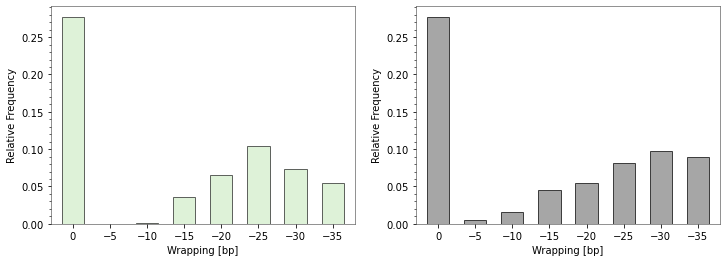

In [10]:
cgreen = '#c8eabe'

dist = 5
pos = np.arange(0,len(maindata[0]))*(-dist)

# Set the width of bars
bar_width = 3  # Adjust as needed

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
plt.minorticks_on() 
ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))
plt.minorticks_on()

ax = ax1
# Plot histogram bars
ax.bar(pos, maindata[0], width=bar_width, color=cgreen, alpha=0.6, edgecolor='black')

# Labels and title
ax.set_xlabel("Wrapping [bp]")
ax.set_ylabel("Relative Frequency")

# Adjust x-ticks for better readability
ax.set_xticks(pos)
ax.set_xlim([np.max(pos)+dist*0.6,np.min(pos)-dist*0.6])


ax = ax2
# Plot histogram bars
ax.bar(pos, maindata[1], width=bar_width, color='gray', alpha=0.7, edgecolor='black')

# Labels and title
ax.set_xlabel("Wrapping [bp]")
ax.set_ylabel("Relative Frequency")

# Adjust x-ticks for better readability
ax.set_xticks(pos)
ax.set_xlim([np.max(pos)+dist*0.6,np.min(pos)-dist*0.6])

# Show the plot
plt.show()


### Reshuffle hists

In [11]:
left_binds = np.array([maindata[0,2*i] + maindata[0,2*i+1] for i in range(len(maindata[0])//2)])
right_binds = np.array([maindata[1,2*i] + maindata[1,2*i+1] for i in range(len(maindata[1])//2)])

print(right_binds)

[0.28189 0.06081 0.13567 0.18709]


### Plot Reshuffled

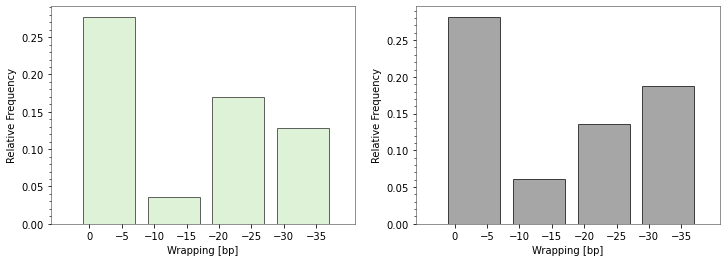

In [12]:
dist = 10
posres = np.arange(0,len(left_binds))*(-dist)-3

# Set the width of bars
bar_width = 8  # Adjust as needed

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
plt.minorticks_on() 
ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))
plt.minorticks_on()

ax = ax1
# Plot histogram bars
ax.bar(posres, left_binds, width=bar_width, color=cgreen, alpha=0.6, edgecolor='black')

# Labels and title
ax.set_xlabel("Wrapping [bp]")
ax.set_ylabel("Relative Frequency")

# Adjust x-ticks for better readability
ax.set_xticks(pos)
ax.set_xlim([np.max(pos)+dist*0.6,np.min(pos)-dist*0.6])


ax = ax2
# Plot histogram bars
ax.bar(posres, right_binds, width=bar_width, color='gray', alpha=0.7, edgecolor='black')

# Labels and title
ax.set_xlabel("Wrapping [bp]")
ax.set_ylabel("Relative Frequency")

# Adjust x-ticks for better readability
ax.set_xticks(pos)
ax.set_xlim([np.max(pos)+dist*0.6,np.min(pos)-dist*0.6])

# Show the plot
plt.show()


### Boltzmann invert

In [13]:
left = left_binds / np.sum(left_binds)
right = right_binds / np.sum(right_binds)

left_fe = -np.log(left)
right_fe = -np.log(right)

left_fe -= left_fe[0]
right_fe -= right_fe[0]


### Plot Free Energy

/usr/lib/python3/dist-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


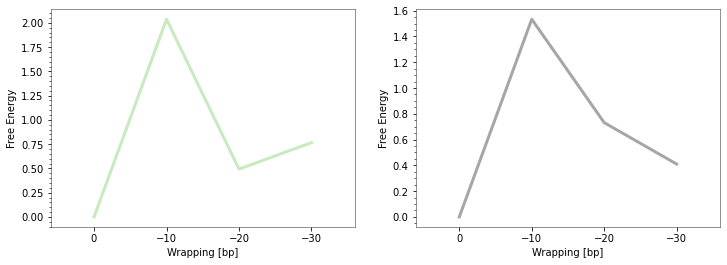

In [14]:
dist = 10
posres = np.arange(0,len(left_fe))*(-dist)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
plt.minorticks_on() 
ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))
plt.minorticks_on()

ax = ax1
# Plot histogram bars
ax.plot(posres,left_fe,lw=3,color=cgreen, alpha=1)

# Labels and title
ax.set_xlabel("Wrapping [bp]")
ax.set_ylabel("Free Energy")

# Adjust x-ticks for better readability
ax.set_xticks(posres)
ax.set_xlim([np.max(posres)+dist*0.6,np.min(posres)-dist*0.6])


ax = ax2
# Plot histogram bars
ax.plot(posres,right_fe,lw=3,color='gray', alpha=0.7)

# Labels and title
ax.set_xlabel("Wrapping [bp]")
ax.set_ylabel("Free Energy")

# Adjust x-ticks for better readability
ax.set_xticks(posres)
ax.set_xlim([np.max(posres)+dist*0.6,np.min(posres)-dist*0.6])

# Show the plot
plt.show()

### Compare left theory with measurement

In [20]:
# thfe_left = np.array([fl['Fdiff'] for fl in Flefts])
# print(thfe_left)

for fl in Flefts:
    print(fl['Fdiff'])

# print(Flefts[0]['Fdiff'])
# print(Flefts[1]['Fdiff'])

126.86084374744178
121.563530751072
113.51855675869388
104.86304888944824
94.90978223102343
84.6079061422281
75.52540456785937
67.20354271849874
56.439373643894214
45.731266726196736
32.66740259757967
22.350019896525282
10.39361252719118
3.0701129774863603


KeyError: 'Fdiff'